# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [3]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [12]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, cerca occorrenze di parole chiave e computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.
$$\newcommand{\pluseq}{\mathrel{+}=}$$
A seguire i criteri per assegnare lo score:
$$"sostenibilita"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 40$$
$$"ambiente"\;or\;"bilancio"\;or\;"rapporto"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 20$$
$$"sostenibilita"\;or\;"ambiente"\;in\;(\,url\,) \implies score \pluseq 10$$

Dopo aver calcolato il punteggio, nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [13]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:

$$tsh \in(\,40, \,60\,)$$

$$(1)\; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$
$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$
$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$
$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$
$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [1]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data/function")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

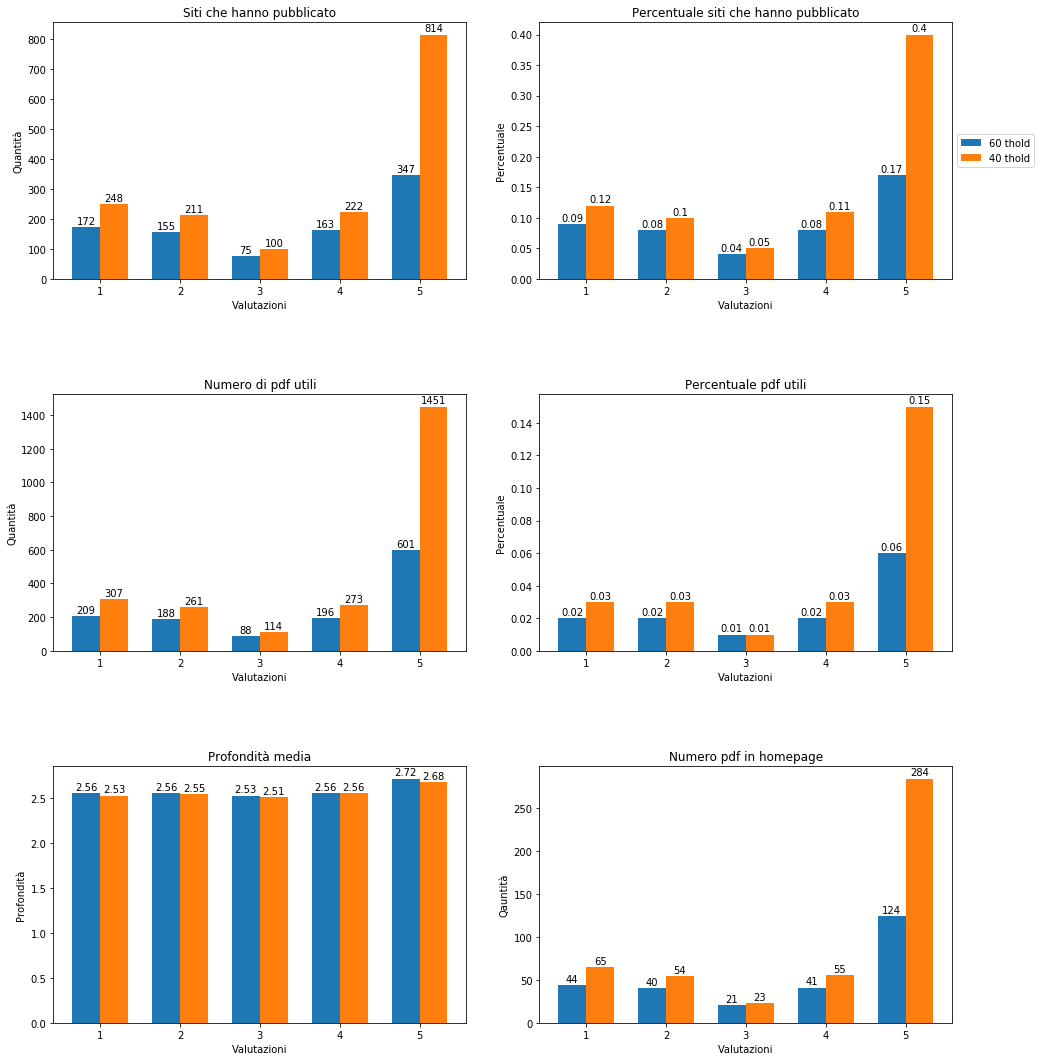

In [68]:
generate_plot(stp)

# Classificatore

Dopo un primo approccio con la funzione di valutazione, si è pensato alla creazione di un classificatore per i link.
Il modello usato è una __support vector machine__, visti gli ottimi risultati sulla lista completa di link.

## Dataset

Le feature sono le stesse prese in considerazione dalla funzione di valutazione precedente, ovvero la presenza di keyword e di 2018 negli elementi del link.

Il dataset è stato creato prendendo come sample positivi i link utili trovati dalla funzione discussa in precedenza, aggiungendo a mano alcuni esempi scartati.

Per gli esempi negativi invece sono stati considerati i link che presentavano più caratteristiche positive, così da rendere il training più difficle e poter capire esattamente quali features determinassero l'utilità o meno di un documento.

In [57]:
dataset_path = "links_classifiers/data/dataset.csv"
data = pd.read_csv(dataset_path)
data.sample(n=5)

,k1_filename,k1_anchor,k1_url,k2_filename,k2_anchor,k2_url,k3_filename,k3_anchor,k3_url,k4_filename,k4_anchor,k4_url,18_filename,18_anchor,18_url,label
517,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0
94,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1
170,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
438,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0
708,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0


## Training

A seguire il training del modello: per semplicità la funzione __generate_svm()__ restituisce un modello già allenato, il nome __c_8_0__ indica il caricamento del modello con parametro c = 8, quello con risultati milgiori.

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from links_classifiers import generate_svm

# generate_svm restituisce una svm allenata sul dataset successivo
s = generate_svm(load_name = 'c_8_0')

# split del training set per testare accuracy e confusion matrix
X = data[data.columns[:-1]]
Y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

y_pred = s.predict(X_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nConfusion matrix:\n{}".format(metrics.confusion_matrix(y_test, y_pred)))

Accuracy: 0.9868421052631579

Confusion matrix:
[[119   2]
 [  1 106]]


## Link di esempio

Provando a riclassificare i link di esempio creati in precedenza, si nota che i link utili sono ritenuti positivi con una probabilità del 97 percento, mentre il link negativo, ma dubbio, risulta non utile al 64 percento.

In [14]:
from csv_links_processing import evaluate_classifier

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Prediction: %s \nProbability: %f \n" %evaluate_classifier(l, s))

Prediction: True 
Probability: 0.970575 

Prediction: True 
Probability: 0.969655 

Prediction: False 
Probability: 0.648720 



# File processing

Dopo aver ottenuto la lista di link utili dal classificatrore, i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [6]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,373
1,file to process,240
2,file processed,187


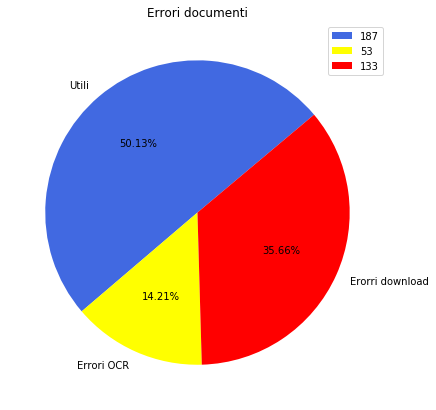

In [12]:
labels = 'Utili', 'Errori OCR', 'Erorri download'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=40)
ax.set_title("Errori documenti")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non sono completamente reperibili tramite Atoka, ci sono quindi alcuni documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

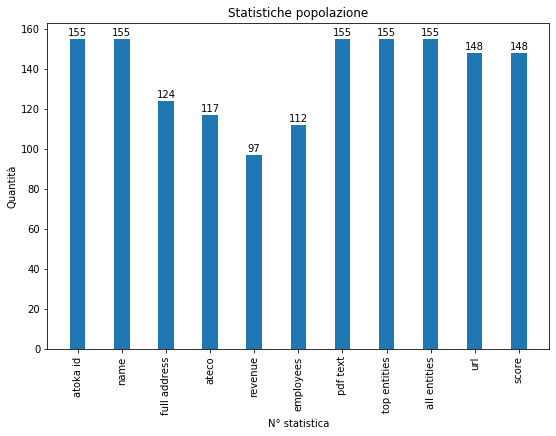

In [27]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)
plt.show()

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [4]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Sustainability History Scientific_research Sus...
1,2,Rosia_Montana Value_added Recycling circular_E...
2,3,Sustainability Ohm's_law Sustainability Sustai...
3,4,List_of_Latin-script_digraphs Arkansas's_1st_c...
4,5,Sustainability Constitution Euro Revenue World...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [6]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 23332

Words:
'sustainability' : 20091
'history' : 9733
'scientific_research' : 18424
'word' : 22992
'ceo' : 3781
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per tutti i modelli che seguono, i parametri __topics__,  __alpha__ e __beta__ sono stati impostati per avere la maggior divisione e chiarezza possibile nella presentazione della distribuzione degli argomenti nei documenti.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

topics = 13
alpha = 0.4
beta =  0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.247183 -0.037537       1        1  30.036076
11    -0.025044 -0.220577       2        1  19.550194
2      0.208960  0.014701       3        1  11.926300
4      0.176076  0.035191       4        1   9.110518
3      0.146361  0.031876       5        1   6.630672
0      0.136451  0.065973       6        1   6.126916
5     -0.124898 -0.179611       7        1   5.301457
9     -0.089510 -0.042286       8        1   4.193337
1     -0.131319 -0.123509       9        1   4.090423
7     -0.129868  0.134080      10        1   1.097076
10    -0.143418  0.075708      11        1   1.055164
12    -0.120728  0.122343      12        1   0.490320
6     -0.150247  0.123648      13        1   0.391548, topic_info=                                         Term         Freq        Total  \
6822                               employment  6237.000000  6237.000000   
9620                                   henkel  1321.000000  1321.000000   
7867                                  finance  2575.000000  2575.000000   
20091                          sustainability  7350.000000  7350.000000   
20113           sustainable_development_goals  1179.000000  1179.000000   
...                                       ...          ...          ...   
5100   corporate_social_responsibility_report     2.741028    90.359475   
17005                                 quercus     1.154764     6.473806   
5377                                  culture     2.627717   698.406991   
5019                      cooperative_society     1.784982   330.721496   
11876                             legambiente     1.174269    24.841606   

      Category  logprob  loglift  
6822   Default  30.0000  30.0000  
9620   Default  29.0000  29.0000  
7867   Default  28.0000  28.0000  
20091  Default  27.0000  27.0000  
20113  Default  26.0000  26.0000  
...        ...      ...      ...  
5100   Topic13  -6.3538   2.0474  
17005  Topic13  -7.2182   3.8189  
5377   Topic13  -6.3960  -0.0399  
5019   Topic13  -6.7827   0.3209  
11876  Topic13  -7.2015   2.4909  

[849 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
241       13  0.260193                 7_
249       12  0.292642                 96
357       11  0.976629             _nagel
402       12  0.292642              _soul
449        6  0.952427  a_better_tomorrow
...      ...       ...                ...
23284      2  0.104782             zoning
23284      6  0.034927             zoning
23284      8  0.034927             zoning
23284      9  0.733476             zoning
23309      4  0.874810               æsir

[2235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 12, 3, 5, 4, 1, 6, 10, 2, 8, 11, 13, 7])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il __totale__ dei __documenti__ è di __170__.
- il numero __medio__ di __entità__ trovate in un testo è di __2496__

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

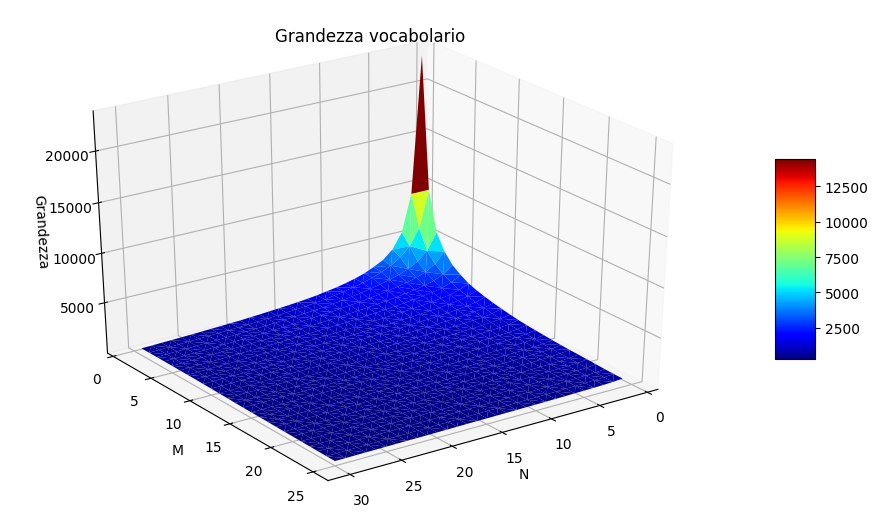

In [2]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare, si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento. Come conseguenza sono cambiati opportunamente anche i parametri alpha e beta, coem discusso in precedenza.

A seguire il modello che considera solo i termini presenti in almeno il __25%__ dei __documenti__ e presenti almeno __15__ volte all'interno di un singolo documento.

In [11]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.25)
M = 15

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 13
alpha = 0.4
beta = 0.7

topics = 10
alpha = 0.7
beta = 0.2


lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 272

Words:
'scientific_research' : 211
'sustainability' : 240
'sustainable_development' : 241
'stakeholder' : 232
'quality' : 184
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.121481 -0.007488       1        1  18.034078
3     -0.185068  0.054598       2        1  13.987957
0      0.224474  0.047111       3        1  13.695126
5     -0.220002 -0.036734       4        1  13.656866
2     -0.142449 -0.079970       5        1  11.268766
4      0.349215 -0.126821       6        1   7.157606
1     -0.070097 -0.151988       7        1   6.092206
6      0.276966 -0.052751       8        1   5.939093
9     -0.185789 -0.004268       9        1   5.914098
7      0.074231  0.358311      10        1   4.254203, topic_info=                              Term         Freq        Total Category  \
76                      employment  6723.000000  6723.000000  Default   
242  sustainable_development_goals  1265.000000  1265.000000  Default   
144                        machine  1085.000000  1085.000000  Default   
268                           work  1822.000000  1822.000000  Default   
84                            euro  2061.000000  2061.000000  Default   
..                             ...          ...          ...      ...   
246                     technology    96.989788  1584.012407  Topic10   
109                         health    59.293671   494.718200  Topic10   
63                       economics    81.518991  2260.334026  Topic10   
148                         market    60.324616   611.311785  Topic10   
64                         economy    59.428288  1248.517424  Topic10   

     logprob  loglift  
76   30.0000  30.0000  
242  29.0000  29.0000  
144  28.0000  28.0000  
268  27.0000  27.0000  
84   26.0000  26.0000  
..       ...      ...  
246  -4.0095   0.3642  
109  -4.5016   1.0358  
63   -4.1833  -0.1652  
148  -4.4844   0.8414  
64   -4.4993   0.1123  

[510 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         6  0.356167    accounting
0         7  0.462393    accounting
0         8  0.068734    accounting
0         9  0.106225    accounting
1         3  0.467898   agriculture
...     ...       ...           ...
268       8  0.023042          work
269       1  0.974681     workforce
270       1  0.951655  working_time
271       2  0.119395         world
271      10  0.835768         world

[908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 1, 6, 3, 5, 2, 7, 10, 8])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di __entità principali__.

La lista di entità questa volta non contiene doppioni, si può pensare alle entità principali come a un set ordinato per importanza, cambierà quindi il criterio di frequenza, essendo il precedente inapplicabile nella parte di conteggio delle occorrenze all'interno di ogni documento.  

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei __modelli__ più __specifici__.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per il nuovo criterio di frequenza, che questa volta non considererà il vincolo intra-documento.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, media del numero di entità complete.

In [12]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 9656

Words:
'sustainability' : 8372
'history' : 4000
'scientific_research' : 7663
'word' : 9528
'strategy' : 8269
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, sistemando quindi alpha e beta.

In [45]:
topics = 11
alpha = 0.02
beta =  0.07

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.283362  0.028923       1        1  42.187106
9      0.041771 -0.253588       2        1  29.560702
8      0.187450  0.082559       3        1   8.424871
7     -0.010059 -0.138652       4        1   6.080984
5     -0.036263 -0.029723       5        1   3.896160
3     -0.124031  0.030164       6        1   3.063574
4     -0.003649  0.114041       7        1   2.640063
10    -0.110327 -0.041869       8        1   2.535885
6     -0.079723  0.101670       9        1   1.555869
0     -0.074154  0.052276      10        1   0.047403
2     -0.074378  0.054199      11        1   0.007382, topic_info=                    Term        Freq       Total Category  logprob  loglift
7373               right  185.000000  185.000000  Default  30.0000  30.0000
2777          employment   92.000000   92.000000  Default  29.0000  29.0000
954              biology   77.000000   77.000000  Default  28.0000  28.0000
2955                euro   71.000000   71.000000  Default  27.0000  27.0000
8372      sustainability  123.000000  123.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
3237      financial_risk    0.000321    4.343519  Topic11  -9.1753  -0.0001
3236     financial_ratio    0.000321    0.953039  Topic11  -9.1753   1.5166
3235  financial_modeling    0.000321    1.417188  Topic11  -9.1753   1.1199
3234    financial_market    0.000321    3.932221  Topic11  -9.1753   0.0993
3233  financial_leverage    0.000321    1.417188  Topic11  -9.1753   1.1199

[1060 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
100       9  1.049275                  _rubicam
112       3  0.938280           _virgin_islands
114       9  1.049275          _walter_thompson
127       4  0.710163                  a_league
153       4  0.984457                 abu_dhabi
...     ...       ...                       ...
9552      7  0.030385                     world
9558      1  0.956277  world_energy_consumption
9569      6  0.479283                   wpp_plc
9569      9  0.479283                   wpp_plc
9655      8  0.942281                       ṛta

[1593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 9, 8, 6, 4, 5, 11, 7, 1, 3])

## Modello con vincoli di frequenza - entità principali

Il criterio per il vincolo di frequenza cambia: 
1. __N__ rimane lo stesso, ovvero specifica la __frequenza inter-documento__ di un' entità.
2. __M__ questa volta diventa la __quantità__ di __entità considerate__ per ogni documento. Un paramentro piccolo indicherà la considerazione delle parole più importanti, mentre un paramentro alto comprenderà una quantità di parole, meno importanti, più elevata.

Per quanto riguarda la restrizione di frequenza inter-documento, ovvero sul parametro N, l'andamento della curva decresce in modo esponenziale, in linea con la curva nell'esempio precedente.

Per quanto riguarda il paramentro M, questa volta porta ad un incremento lineare del vocabolario, poichè ad ogni step si include un numero di entità proporzionale al totale dei documenti.

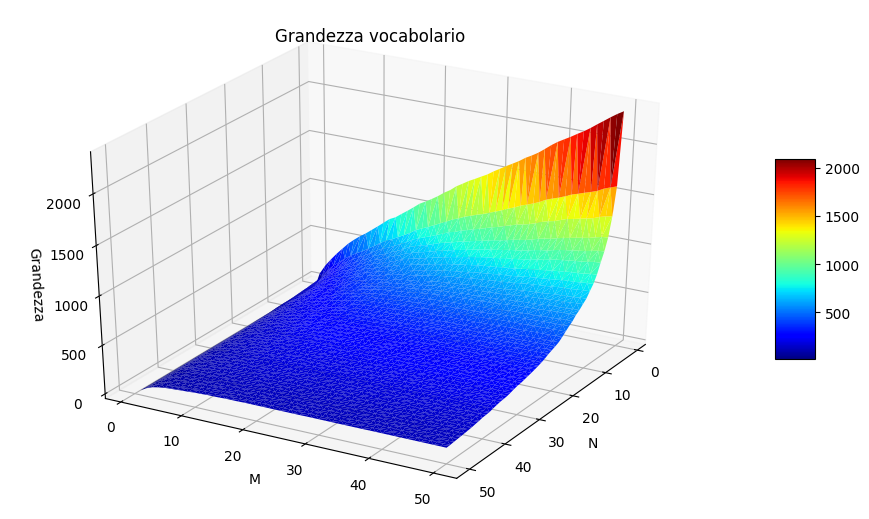

In [3]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")

Il modelli che seguono mantengono la restrizione della frequenza adottata in precedenza per quanto riguarda N, ovvero si considerano i termini presenti nel __25%__ dei __documenti__, mentre per __M__ si usano __50__ e __30__ rispettivamente.

### M = 50

In [13]:
from lda_topic_model import preprocess_freq_count_relevant

N = round(170 * 0.25)
M = 50

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.9
beta = 0.2

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 154

Words:
'scientific_research' : 117
'strategy' : 129
'sustainable_development' : 132
'risk_management' : 111
'quality' : 100
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.123371 -0.130264       1        1  15.154172
0     -0.242994 -0.093481       2        1  13.355489
7      0.191121 -0.136248       3        1  13.205396
9      0.181300 -0.028464       4        1  10.990669
1     -0.243050  0.018570       5        1  10.875491
5      0.113848  0.094263       6        1   9.166371
2     -0.251506 -0.009409       7        1   8.159883
4      0.090202  0.140238       8        1   7.492566
6      0.027273  0.107522       9        1   6.037824
8      0.010434  0.037273      10        1   5.562140, topic_info=                        Term       Freq      Total Category  logprob  loglift
64                  industry  56.000000  56.000000  Default  30.0000  30.0000
32                 economics  87.000000  87.000000  Default  29.0000  29.0000
144                   value_  81.000000  81.000000  Default  28.0000  28.0000
132  sustainable_development  57.000000  57.000000  Default  27.0000  27.0000
22               corporation  50.000000  50.000000  Default  26.0000  26.0000
..                       ...        ...        ...      ...      ...      ...
113                   safety   0.635214  39.178302  Topic10  -5.7780  -1.2327
42          environmentalism   0.470858  29.399779  Topic10  -6.0774  -1.2450
14             communication   0.423615  24.009542  Topic10  -6.1831  -1.1482
110                     risk   0.427391  27.080082  Topic10  -6.1743  -1.2597
37                employment   0.431731  61.949742  Topic10  -6.1641  -2.0771

[399 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         3  0.202496     accounting
0         7  0.708735     accounting
1         3  0.051556  air_pollution
1         4  0.824889  air_pollution
1         8  0.051556  air_pollution
...     ...       ...            ...
151       7  0.145187           work
152       1  0.652109      workforce
153       5  0.509875          world
153       6  0.196106          world
153       8  0.235327          world

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 10, 2, 6, 3, 5, 7, 9])

### M = 30

In [14]:
N = round(170 * 0.25)
M = 30

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.7
beta = 0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 153

Words:
'scientific_research' : 117
'strategy' : 128
'sustainable_development' : 131
'risk_management' : 111
'quality' : 100
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.245624 -0.070111       1        1  20.072699
8     -0.170941 -0.053989       2        1  16.397506
7     -0.160501  0.073312       3        1  15.050408
6      0.151262  0.182766       4        1   9.560299
5      0.006835 -0.048206       5        1   8.503373
9     -0.088269 -0.004619       6        1   7.175628
4     -0.032202  0.034442       7        1   6.751737
2     -0.013761  0.079017       8        1   6.235095
3     -0.028797 -0.097959       9        1   5.264883
1      0.090749 -0.094653      10        1   4.988372, topic_info=            Term       Freq      Total Category  logprob  loglift
7       business  71.000000  71.000000  Default  30.0000  30.0000
22   corporation  31.000000  31.000000  Default  29.0000  29.0000
39        energy  25.000000  25.000000  Default  28.0000  28.0000
110         risk  15.000000  15.000000  Default  27.0000  27.0000
125    sociology  38.000000  38.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
71         italy   0.353810   9.963061  Topic10  -5.8312  -0.3398
134   technology   0.374465  23.185984  Topic10  -5.7745  -1.1277
22   corporation   0.378557  31.440820  Topic10  -5.7636  -1.4214
16       company   0.366160  57.612925  Topic10  -5.7969  -2.0604
7       business   0.358165  71.686577  Topic10  -5.8190  -2.3010

[396 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         3  0.230399     accounting
0         4  0.230399     accounting
1         6  0.249105  air_pollution
1         7  0.249105  air_pollution
1         8  0.332140  air_pollution
...     ...       ...            ...
151       6  0.555516      workforce
152       1  0.280999          world
152       3  0.070250          world
152       4  0.070250          world
152       8  0.491748          world

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 7, 6, 10, 5, 3, 4, 2])